# Importing libraries

In [1]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from collections import Counter
import string
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Importing data

In [2]:
#load lin-spam dataset 
df=pd.read_csv('messages.csv')
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


## Processing and cleaning data

In [3]:
# converting all messages to lower case
df['message'] = df['message'].str.lower()

In [4]:
# check data once 
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [5]:
# checing null values 
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [6]:
#fill na values
df.fillna(df['subject'].mode().values[0],inplace=True)

In [7]:
# let's once again 
df.isnull().sum()

subject    0
message    0
label      0
dtype: int64

In [8]:
#combine two columns
df['sub_mssg']=df['subject']+df['message']
df.head

<bound method NDFrame.head of                                                 subject  \
0               job posting - apple-iss research center   
1                                      sociolinguistics   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
...                                                 ...   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  \
0     content - length : 3386 apple-iss research cen...      0   
1     lang classification grimes , joseph e . and ba...      0   
2     i am posting this inquiry for sergei atamas ( ...      0 

In [9]:
df['sub_mssg'].describe()

count                                                  2893
unique                                                 2876
top       re := 20 the virtual girlfriend and virtual bo...
freq                                                      4
Name: sub_mssg, dtype: object

In [10]:
df['length']=df['sub_mssg'].apply(len)
df.head()

,subject,message,label,sub_mssg,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...,2895
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j...",1816
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1485
3,risk,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328
4,request book information,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070


In [11]:
#now i'm going to drop un-necessary features 
df.drop('subject',axis=1,inplace=True)

In [12]:
# check it once 
df.head()

,message,label,sub_mssg,length
0,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...,2895
1,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j...",1816
2,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1485
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070


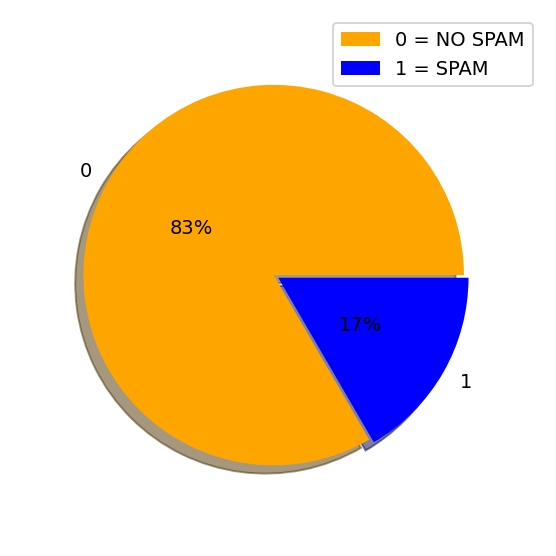

In [13]:
#visaulizing the dataset
lb=df['label'].value_counts().index.tolist()
val=df['label'].value_counts().values.tolist()
exp=(0.025,0)
clr=('orange','blue')
plt.figure(figsize=(10,5),dpi=140)
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.legend(["0 = NO SPAM",'1 = SPAM'])
plt.show()


In [14]:
df['message'][0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

In [15]:
#make a token function
import re
def decontact(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
mssg=decontact(df['message'][70])
mssg

'hi , i am new to the list . and since english is not my first language , i apologize for the mistakes you might find below : - ) . i hope that you will not mind if some of my explanations are in french . for my ph . d . semiotics , i am writing a dissertation on discourse and science-fiction and i need some information about the construction of neologisms in french and in english . ( neologisms are useful in sf , specially in the scientific field ! ) in french , neologisms are made in 5 different ways ( i hope these are the right english words ) : derivation ; composition ; imitation ; pure invention ; amalgam . one might also add borrowings from other languages . here are some examples ( sorry , the explanations are in french ) : - derivation : mot derive : " position " peut produire le verbe " positionner " ; - composition : mot compose : si " monotone " est decompose ( " mono " / " tone " ) , on peut recomposer " polytone " ; a partir de " telephone " on peut produire en science-fi

In [17]:
#REPLACING NUMBERS
df['sub_mssg']=df['sub_mssg'].str.replace(r'\d+(\.\d+)?', 'numbers')
df['sub_mssg'][0]

"job posting - apple-iss research centercontent - length : numbers apple-iss research center a us $ numbers million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statis

In [18]:
#CONVRTING EVERYTHING TO LOWERCASE
df['sub_mssg']=df['sub_mssg'].str.lower()
#REPLACING NEXT LINES BY 'WHITE SPACE'
df['sub_mssg']=df['sub_mssg'].str.replace(r'\n'," ") 
# REPLACING EMAIL IDs BY 'MAILID'
df['sub_mssg']=df['sub_mssg'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')
# REPLACING URLs  BY 'Links'
df['sub_mssg']=df['sub_mssg'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')
# REPLACING CURRENCY SIGNS BY 'MONEY'
df['sub_mssg']=df['sub_mssg'].str.replace(r'£|\$', 'Money')
# REPLACING LARGE WHITE SPACE BY SINGLE WHITE SPACE
df['sub_mssg']=df['sub_mssg'].str.replace(r'\s+', ' ')

# REPLACING LEADING AND TRAILING WHITE SPACE BY SINGLE WHITE SPACE
df['sub_mssg']=df['sub_mssg'].str.replace(r'^\s+|\s+?$', '')
#REPLACING CONTACT NUMBERS
df['sub_mssg']=df['sub_mssg'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','contact number')
#REPLACING SPECIAL CHARACTERS  BY WHITE SPACE 
df['sub_mssg']=df['sub_mssg'].str.replace(r"[^a-zA-Z0-9]+", " ")

In [19]:
#CONVRTING EVERYTHING TO LOWERCASE
df['message']=df['message'].str.lower()
#REPLACING NEXT LINES BY 'WHITE SPACE'
df['message']=df['message'].str.replace(r'\n'," ") 
# REPLACING EMAIL IDs BY 'MAILID'
df['message']=df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')
# REPLACING URLs  BY 'Links'
df['message']=df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')
# REPLACING CURRENCY SIGNS BY 'MONEY'
df['message']=df['message'].str.replace(r'£|\$', 'Money')
# REPLACING LARGE WHITE SPACE BY SINGLE WHITE SPACE
df['message']=df['message'].str.replace(r'\s+', ' ')

# REPLACING LEADING AND TRAILING WHITE SPACE BY SINGLE WHITE SPACE
df['message']=df['message'].str.replace(r'^\s+|\s+?$', '')
#REPLACING CONTACT NUMBERS
df['message']=df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','contact number')
#REPLACING SPECIAL CHARACTERS  BY WHITE SPACE 
df['message']=df['message'].str.replace(r"[^a-zA-Z0-9]+", " ")

In [20]:
df['sub_mssg'][0]

'job posting apple iss research centercontent length numbers apple iss research center a us Money numbers million joint venture between apple computer inc and the institute of systems science of the national university of singapore located in singapore is looking for a senior speech scientist the successful candidate will have research expertise in computational linguistics including natural language processing and english and chinese statistical language modeling knowledge of state of the art corpus based n gram language models cache language models and part of speech language models are required a text to speech project leader the successful candidate will have research expertise expertise in two or more of the following areas computational linguistics including natural language parsing lexical database design and statistical language modeling text tokenization and normalization prosodic analysis substantial knowledge of the phonology syntax and semantics of chinese is required knowl

In [21]:
df.head()

,message,label,sub_mssg,length
0,content length 3386 apple iss research center ...,0,job posting apple iss research centercontent l...,2895
1,lang classification grimes joseph e and barbar...,0,sociolinguisticslang classification grimes jos...,1816
2,i am posting this inquiry for sergei atamas sa...,0,query letter frequencies for text identificati...,1485
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070


## Tokenizing

In [22]:
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# removing stopwords 
stop = stopwords.words('english')
df['Cleaned_Text'] = df['sub_mssg'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [23]:
df.head()

,message,label,sub_mssg,length,Cleaned_Text
0,content length 3386 apple iss research center ...,0,job posting apple iss research centercontent l...,2895,job posting apple iss research centercontent l...
1,lang classification grimes joseph e and barbar...,0,sociolinguisticslang classification grimes jos...,1816,sociolinguisticslang classification grimes jos...
2,i am posting this inquiry for sergei atamas sa...,0,query letter frequencies for text identificati...,1485,query letter frequencies text identificationi ...
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328,riska colleague researching differing degrees ...
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070,request book informationearlier morning phone ...


In [24]:
df.drop('message',axis=1,inplace=True)
df.drop('sub_mssg',axis=1,inplace=True)
df.head()

,label,length,Cleaned_Text
0,0,2895,job posting apple iss research centercontent l...
1,0,1816,sociolinguisticslang classification grimes jos...
2,0,1485,query letter frequencies text identificationi ...
3,0,328,riska colleague researching differing degrees ...
4,0,1070,request book informationearlier morning phone ...


In [25]:
df.isnull().sum()

label           0
length          0
Cleaned_Text    0
dtype: int64

In [26]:
df['lgth_clean']=df['Cleaned_Text'].apply(len)
df.head()

,label,length,Cleaned_Text,lgth_clean
0,0,2895,job posting apple iss research centercontent l...,2108
1,0,1816,sociolinguisticslang classification grimes jos...,1506
2,0,1485,query letter frequencies text identificationi ...,1150
3,0,328,riska colleague researching differing degrees ...,216
4,0,1070,request book informationearlier morning phone ...,653


In [27]:
original_length=sum(df['length'])
after_cleaning=sum(df['lgth_clean'])

In [28]:
print("original_length",original_length)
print('after_cleaning',after_cleaning)

original_length 9437398
after_cleaning 6847913


# Training and Testing

In [29]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.pipeline import Pipeline

In [30]:
# Convert text into vectors using TF-IDF
tvec = TfidfVectorizer()
lr = LogisticRegression(solver = "lbfgs")

In [31]:
#split data
X = df.Cleaned_Text
Y = df.label

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 225,stratify=Y)

In [32]:
print (X_test)

2100    searching west african indian textsdear collea...
1498    sum reactions synthetic speecha number weeks a...
2110    youth gang lipolaliapardon neologism lipogram ...
910     call paperscall papers numbersst annual confer...
719     secret hardcore sex site click check http www ...
                              ...                        
491     sum referencehere reference posted request sha...
617     endangered languages workshopthe foundation en...
439     japanese conferencecontent length numbers x su...
82      sum v initial languagesseveral weeks ago poste...
2028    want best economical hunting vacation life wan...
Name: Cleaned_Text, Length: 290, dtype: object


In [33]:
# Convert text into vectors using TF-IDF
model = Pipeline([('vectorizer',tvec),('classifier',lr)])

model.fit(X_train,Y_train)


from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

confusion_matrix(y_pred,Y_test)

array([[242,   8],
       [  0,  40]])

In [34]:
print("Accuracy : ", accuracy_score(y_pred,Y_test))
print("Precision : ", precision_score(y_pred,Y_test, average = 'weighted'))
print("Recall : ", recall_score(y_pred,Y_test, average = 'weighted'))

Accuracy :  0.9724137931034482
Precision :  0.9770114942528735
Recall :  0.9724137931034482


In [35]:
#training the model
mnb = MultinomialNB()
model_2 = Pipeline([('vectorizer',tvec),('classifier',mnb)])
model_2.fit(X_train,Y_train)


y_pred = model_2.predict(X_test)

print(confusion_matrix(y_pred,Y_test))
print("Accuracy : ", accuracy_score(y_pred,Y_test))
print("Precision : ", precision_score(y_pred,Y_test, average = 'weighted'))
print("Recall : ", recall_score(y_pred,Y_test, average = 'weighted'))

[[242  37]
 [  0  11]]
Accuracy :  0.8724137931034482
Precision :  0.9707614942528735
Recall :  0.8724137931034482


# Saving and loading the model

In [36]:
import pickle
#save the model
with open ('logi_classifier_pickle', 'wb') as f:
        pickle.dump(model, f)

In [37]:
#load the model
with open ('logi_classifier_pickle', 'rb') as f:
        logi = pickle.load(f)

In [38]:
import pickle
#save the model
with open ('nb_classifier_pickle', 'wb') as f:
        pickle.dump(model_2, f)

In [39]:
#load the model
with open ('nb_classifier_pickle', 'rb') as f:
        nb = pickle.load(f)

In [40]:
logi.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0])

In [41]:
nb.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0])

## Importing demo dataset

In [42]:
#import data
df2 = pd.read_csv('email.csv')
df2.head(10)

,Unnamed: 0,Subject,Address,messages
0,0,Innovation Center Initiatives and Partnerships,Weijie Zhao <weijiezhao@mail.adelphi.edu>,Innovation Center Initiatives and Partnerships...
1,1,internship,Weijie Zhao <weijiezhao@mail.adelphi.edu>,Why Take the Innovation Center Internship Prog...
2,2,innovation center,Weijie Zhao <weijiezhao@mail.adelphi.edu>,career-immersion curriculum that allows you to...
3,3,Fwd: Artificial Intelligence and Design Thinki...,Weijie Zhao <weijiezhao@mail.adelphi.edu>,---------- Forwarded message ---------From: Ta...
4,4,Fwd: Artificial Intelligence and Design Thinki...,Weijie Zhao <weijiezhao@mail.adelphi.edu>,---------- Forwarded message ---------From: Ta...
5,5,Tomorrow | Building a Climate Resilient Health...,Axios Events <events@axios.com>,"On December 15th, join Axios for a virtual eve..."
6,6,12.14.21 | 👩‍⚕️ A beginner's guide to picking ...,The Daily Good <hello@thegoodtrade.com>,Start your day with something good.December 14...
7,7,2021's Solid Seven ⚠️,"""theCLIKK"" <team@theclikk.com>",TODAY: we break into the Greatest CLIKKs Top T...
8,8,Thursday | S&P Global and Moody's leaders disc...,Axios Events <events@axios.com>,"On December 16th, join Axios for a virtual eve..."
9,9,Axios Pro Rata: Stock transfer agents in the s...,Dan Primack <dan@axios.com>,"Plus, solving single-use plastics via SPAC | T..."


In [43]:
#show null
df2.isnull().sum()

Unnamed: 0    0
Subject       0
Address       0
messages      0
dtype: int64

In [44]:
#check messages
msg = decontact(df2['messages'][70])
msg

'Start your day with something good.November 30, 2021https://mailchi.mp/thegoodtrade/113021-your-guide-to-head-to-toe-self-massage?e=e7ab5448b7Take the credit that you have earned.Warmly,AmyAnn Cadwell& THE GOOD TRADE TEAMhttps://open.spotify.com/track/01K4zKU104LyJ8gMb7227B?si=c11f5e182e5d4736We love that Taylor Swift is slowly re-releasing her entire catalogue to regain ownership of her music rights. This tearjerker of a track enlists fellow blondie (and sad girl) Phoebe Bridgers—grab the tissues! 😢LISTEN TO "NOTHING NEW (TAYLOR\'S VERSION)" (https://open.spotify.com/track/01K4zKU104LyJ8gMb7227B?si=c11f5e182e5d4736)https://www.theoriginaldish.com/2020/12/13/creamy-red-pepper-pasta-with-burrata-herbs/Holy burrata 😍 This recipe is for the cheese-lovers! Creamy red pepper sauce, caramelized shallots, lots of garlic, and a heaping spoonful of burrata make this pasta warm and comforting.MAKE RED PEPPER PASTA WITH BURRATA (https://www.theoriginaldish.com/2020/12/13/creamy-red-pepper-pasta-

In [45]:
#CONVRTING EVERYTHING TO LOWERCASE
df2['messages']=df2['messages'].str.lower()
#REPLACING NEXT LINES BY 'WHITE SPACE'
df2['messages']=df2['messages'].str.replace(r'\n'," ") 
# REPLACING EMAIL IDs BY 'MAILID'
df2['messages']=df2['messages'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')
# REPLACING URLs  BY 'Links'
df2['messages']=df2['messages'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')
# REPLACING CURRENCY SIGNS BY 'MONEY'
df2['messages']=df2['messages'].str.replace(r'£|\$', 'Money')
# REPLACING LARGE WHITE SPACE BY SINGLE WHITE SPACE
df2['messages']=df2['messages'].str.replace(r'\s+', ' ')

# REPLACING LEADING AND TRAILING WHITE SPACE BY SINGLE WHITE SPACE
df2['messages']=df2['messages'].str.replace(r'^\s+|\s+?$', '')
#REPLACING CONTACT NUMBERS
df2['messages']=df2['messages'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','contact number')
#REPLACING SPECIAL CHARACTERS  BY WHITE SPACE 
df2['messages']=df2['messages'].str.replace(r"[^a-zA-Z0-9]+", " ")

In [46]:
df2.head()

,Unnamed: 0,Subject,Address,messages
0,0,Innovation Center Initiatives and Partnerships,Weijie Zhao <weijiezhao@mail.adelphi.edu>,innovation center initiatives and partnerships...
1,1,internship,Weijie Zhao <weijiezhao@mail.adelphi.edu>,why take the innovation center internship prog...
2,2,innovation center,Weijie Zhao <weijiezhao@mail.adelphi.edu>,career immersion curriculum that allows you to...
3,3,Fwd: Artificial Intelligence and Design Thinki...,Weijie Zhao <weijiezhao@mail.adelphi.edu>,forwarded message from tara gercke date mon n...
4,4,Fwd: Artificial Intelligence and Design Thinki...,Weijie Zhao <weijiezhao@mail.adelphi.edu>,forwarded message from tara gercke date mon d...


## Prediction

In [47]:
pred = logi.predict(df2.messages)

In [48]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0])

In [49]:
#count the array
mask = np.unique(pred)
tmp = {}
for v in mask:
    tmp[v] = np.sum(pred == v)
print("mask：")
print(mask)
print("result：")
print(tmp)

mask：
[0 1]
result：
{0: 120, 1: 8}


In [50]:
def np_count(nparray, x):
    i = 0
    for n in nparray:
        if n == x:
            i += 1
    return i

In [51]:
#show the result of prediction 
nospam = np_count(pred, 0)
spam = np_count (pred, 1)
print ('no spam: ')
print (nospam)
print ('spam: ')
print (spam)

no spam: 
120
spam: 
8


## Visualization

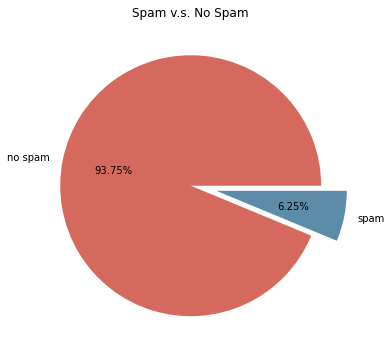

In [52]:
#pie gragh
plt.figure(figsize=(10, 6))
y = np.array([nospam, spam])

plt.pie(y,
        labels=['no spam','spam'], 
        colors=["#d5695d", "#5d8ca8", "#65a479", "#a564c9"], 
        explode=(0, 0.2), 
        autopct='%.2f%%', 
       )
plt.title("Spam v.s. No Spam") # title
plt.show()

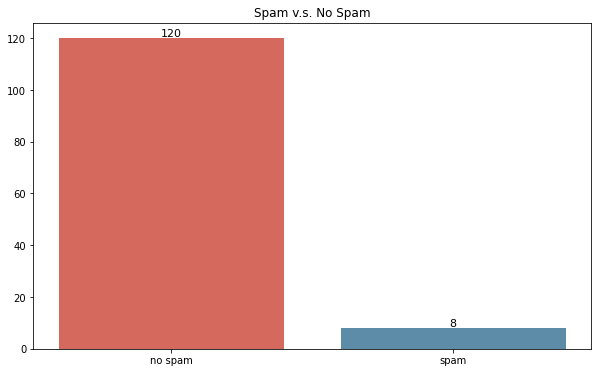

In [53]:
plt.figure(figsize=(10, 6))
x = np.array(["no spam", "spam"])
y = np.array([nospam, spam])


for a,b in zip(x,y):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11)  


plt.title("Spam v.s. No Spam") # title
plt.bar(x, y,  color = ["#d5695d", "#5d8ca8"])
plt.show()